## Transfer Learning with TensorFlow Part 3: Scaling up

In [1]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
# get 10% of Food101 data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
# unzip_data("101_food_classes_10_percent.zip")

In [4]:
# set up the train and test dir
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
# files in the directories
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 direc

In [95]:
# set up the inputs
IMG_SIZE=(224, 224)

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_all_10_percent = image_dataset_from_directory(directory=train_dir, 
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE)
test_data = image_dataset_from_directory(directory=test_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE,
                                        shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
train_data_all_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
len(train_data_all_10_percent.class_names)

101

In [9]:
# create the modelcheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                      verbose=1, 
                                      save_best_only=True, 
                                      save_weights_only=True, 
                                      monitor="val_accuracy")

In [10]:
# create the data augmetation layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomWidth, RandomZoom, RandomRotation, Rescaling

augmentation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomRotation(0.2)
    # Rescaling(1/255.) since efficientnet does have Rescaling build in base layer, therefore it is not need. Other model might this
], name="augmentation_layer")

In [11]:
# set up the base EfficientNetB0 freeze the layers
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

In [12]:
# stack the layers
input_shape = (224, 224, 3)
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

inputs = Input(shape=input_shape, name="input_layer")
x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# compile the model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=["accuracy"])

In [15]:
# fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                          callbacks=[checkpoint_callback])

Epoch 1/5


2022-01-25 18:10:34.992954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-01-25 18:10:45.533007: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-25 18:10:45.634180: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


237/237 [==============================] - ETA: 0s - loss: 3.4857 - accuracy: 0.2426
Epoch 00001: val_accuracy improved from -inf to 0.43671, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 96s 309ms/step - loss: 3.4857 - accuracy: 0.2426 - val_loss: 2.5555 - val_accuracy: 0.4367
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3839 - accuracy: 0.4519
Epoch 00002: val_accuracy improved from 0.43671 to 0.49364, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 57s 240ms/step - loss: 2.3839 - accuracy: 0.4519 - val_loss: 2.1187 - val_accuracy: 0.4936
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0113 - accuracy: 0.5218
Epoch 00003: val_accuracy improved from 0.49364 to 0.50662, saving model to 101_classes_10_percent_data_model_checkpoint/checkpoint.ckpt
237/237 [==============================] - 54s 22

In [16]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 67s 85ms/step - loss: 1.7082 - accuracy: 0.5546


[1.7082221508026123, 0.5545742511749268]

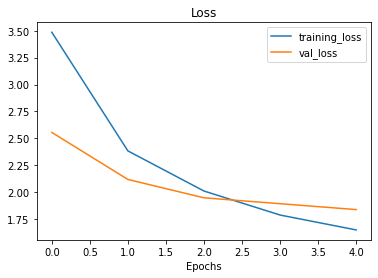

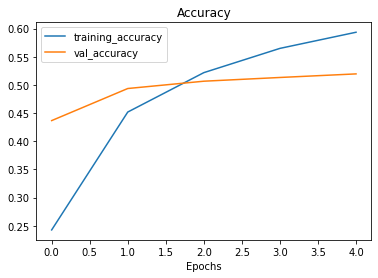

In [17]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tune the model

In [18]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
augmentation_layer True
efficientnetb0 False
global_average_pooling_2d True
output_layer True


In [19]:
for i, layer in enumerate(model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
# unfreeze the last five layer of efficientnetb0
for layer in model.layers[2].layers[-5:]:
    print(layer, layer.trainable)

for layer in model.layers[2].layers[-5:]:
    layer.trainable = True

print("\n")

for layer in model.layers[2].layers[-5:]:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7fb0541b16d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb0541abf40> False
<keras.layers.convolutional.Conv2D object at 0x7fb055fb7520> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb0541b10a0> False
<keras.layers.core.activation.Activation object at 0x7fb0541b6e50> False


<keras.layers.convolutional.Conv2D object at 0x7fb0541b16d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb0541abf40> True
<keras.layers.convolutional.Conv2D object at 0x7fb055fb7520> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fb0541b10a0> True
<keras.layers.core.activation.Activation object at 0x7fb0541b6e50> True


In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 41s 175ms/step - loss: 1.5167 - accuracy: 0.6294 - val_loss: 1.8177 - val_accuracy: 0.5215
Epoch 6/10
237/237 [==============================] - 41s 174ms/step - loss: 1.4217 - accuracy: 0.6523 - val_loss: 1.7690 - val_accuracy: 0.5297
Epoch 7/10
237/237 [==============================] - 38s 160ms/step - loss: 1.3422 - accuracy: 0.6675 - val_loss: 1.7817 - val_accuracy: 0.5246
Epoch 8/10
237/237 [==============================] - 38s 160ms/step - loss: 1.2489 - accuracy: 0.6859 - val_loss: 1.7517 - val_accuracy: 0.5310
Epoch 9/10
237/237 [==============================] - 37s 156ms/step - loss: 1.1927 - accuracy: 0.7017 - val_loss: 1.7614 - val_accuracy: 0.5336
Epoch 10/10
237/237 [==============================] - 36s 152ms/step - loss: 1.1343 - accuracy: 0.7179 - val_loss: 1.7934 - val_accuracy: 0.5196


In [22]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 55s 69ms/step - loss: 1.6184 - accuracy: 0.5710


[1.618414282798767, 0.5710495114326477]

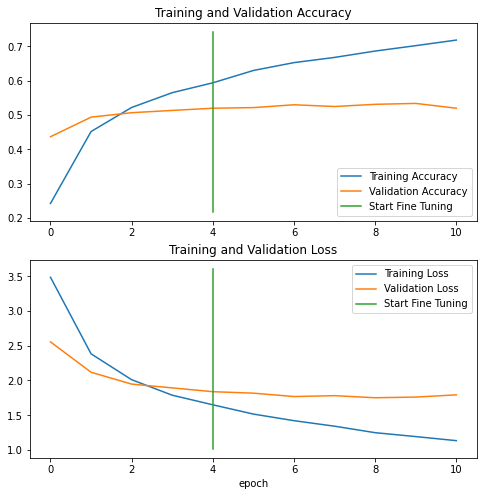

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Making predictions with trained model

In [24]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 52s 65ms/step


In [25]:
# prediction length and shape
len(preds_probs), preds_probs.shape

(25250, (25250, 101))

In [26]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.8131902e-01, 1.4145192e-04, 1.6805010e-01, 3.4996867e-07,
        1.1208288e-05, 2.4432078e-05, 1.8913689e-04, 5.6793226e-05,
        6.4151050e-03, 1.6639031e-03, 3.6238569e-05, 1.2979925e-05,
        2.6368508e-03, 5.5146002e-06, 1.8360306e-02, 2.4316676e-03,
        8.4080282e-05, 1.1808279e-03, 3.2680519e-03, 1.9190149e-05,
        2.1382970e-04, 1.9899057e-04, 6.4109219e-04, 2.6831869e-04,
        3.7045035e-04, 8.5773086e-04, 3.7461377e-04, 1.0823956e-04,
        8.9874856e-02, 2.8754261e-03, 1.4657660e-05, 6.0133555e-04,
        1.1820397e-03, 3.8793105e-06, 4.4063763e-03, 1.2750576e-04,
        1.0241922e-03, 1.1980286e-03, 1.8829256e-02, 2.9233199e-05,
        5.9823302e-04, 2.0826478e-03, 3.3992573e-04, 2.8163340e-05,
        1.6646303e-04, 2.3893529e-04, 1.9068879e-03, 3.2964107e-04,
        5.1274969e-06, 2.2495292e-02, 6.7253096e-04, 1.9212737e-04,
        8.6512052e-02, 7.0284717e-03, 6.1378327e-05, 1.0442986e-02,
        6.3717291e-03, 3.3543161e-03, 7.2216783e

In [27]:
preds_probs[0].argmax()

0

In [28]:
train_data_all_10_percent.class_names[preds_probs[0].argmax()]

'apple_pie'

In [29]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  0, 78, 29,  0,  9,  0])

In [30]:
# How many pred classes do we have?
len(pred_classes)

25250

In [31]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.571049504950495

In [34]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(all_classes_10_percent_fine_tune_results[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [37]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [38]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

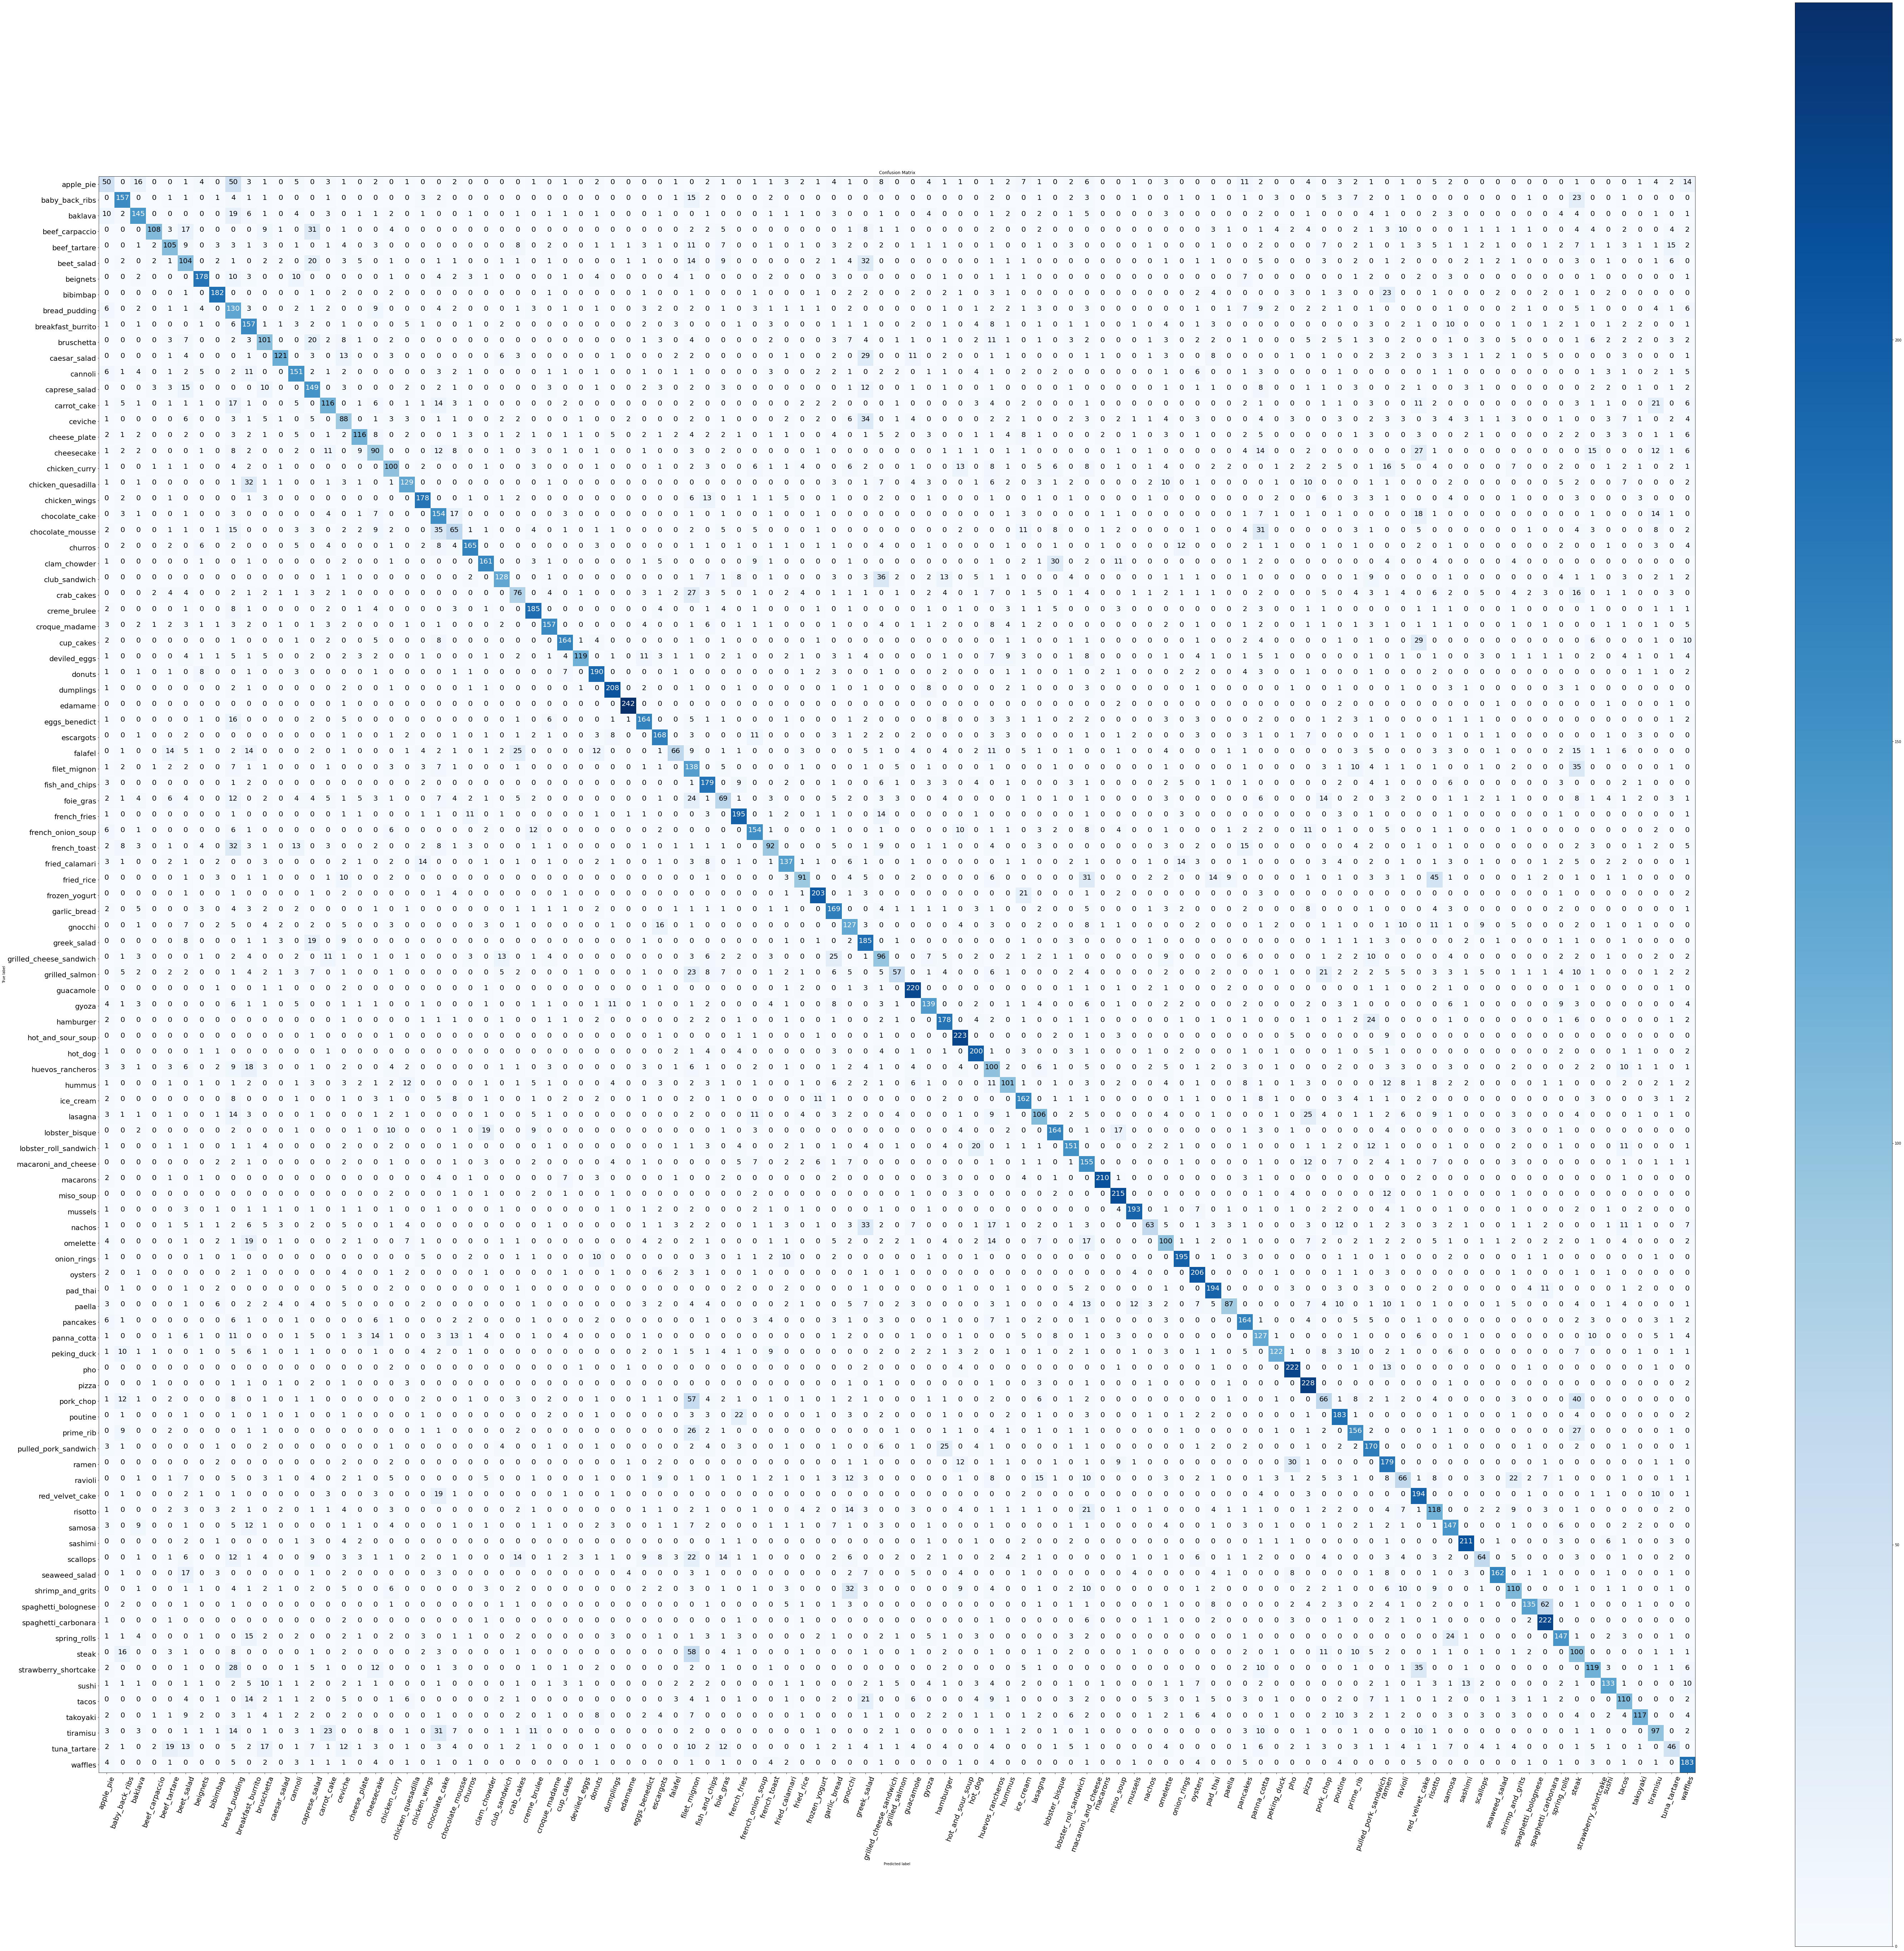

In [39]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [41]:
len(pred_classes), len(y_labels)

(25250, 25250)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.28      0.20      0.23       250
           1       0.61      0.63      0.62       250
           2       0.63      0.58      0.60       250
           3       0.86      0.43      0.58       250
           4       0.52      0.42      0.47       250
           5       0.33      0.42      0.37       250
           6       0.76      0.71      0.73       250
           7       0.79      0.73      0.76       250
           8       0.23      0.52      0.32       250
           9       0.40      0.63      0.49       250
          10       0.43      0.40      0.42       250
          11       0.79      0.48      0.60       250
          12       0.60      0.60      0.60       250
          13       0.43      0.60      0.50       250
          14       0.55      0.46      0.50       250
          15       0.32      0.35      0.34       250
          16       0.69      0.46      0.56       250
          17       0.42    

## Visualize

In [46]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2824858757062147,
  'recall': 0.2,
  'f1-score': 0.234192037470726,
  'support': 250},
 '1': {'precision': 0.6061776061776062,
  'recall': 0.628,
  'f1-score': 0.6168958742632613,
  'support': 250},
 '2': {'precision': 0.6277056277056277,
  'recall': 0.58,
  'f1-score': 0.6029106029106028,
  'support': 250},
 '3': {'precision': 0.864, 'recall': 0.432, 'f1-score': 0.576, 'support': 250},
 '4': {'precision': 0.5223880597014925,
  'recall': 0.42,
  'f1-score': 0.46563192904656314,
  'support': 250},
 '5': {'precision': 0.33121019108280253,
  'recall': 0.416,
  'f1-score': 0.3687943262411348,
  'support': 250},
 '6': {'precision': 0.7574468085106383,
  'recall': 0.712,
  'f1-score': 0.734020618556701,
  'support': 250},
 '7': {'precision': 0.7947598253275109,
  'recall': 0.728,
  'f1-score': 0.7599164926931106,
  'support': 250},
 '8': {'precision': 0.22807017543859648,
  'recall': 0.52,
  'f1-score': 0.31707317073170727,
  'support': 250},
 '9': {'precision': 0.40463

In [85]:
# from more_itertools import take
# take(5, classification_report_dict.items())

In [58]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [84]:
class_f1_scores = {class_names[int(k)]:v["f1-score"] for (k,v) in classification_report_dict.items() if k not in ["accuracy", "macro avg", "weighted avg"]}
class_f1_scores

{'apple_pie': 0.234192037470726,
 'baby_back_ribs': 0.6168958742632613,
 'baklava': 0.6029106029106028,
 'beef_carpaccio': 0.576,
 'beef_tartare': 0.46563192904656314,
 'beet_salad': 0.3687943262411348,
 'beignets': 0.734020618556701,
 'bibimbap': 0.7599164926931106,
 'bread_pudding': 0.31707317073170727,
 'breakfast_burrito': 0.49216300940438873,
 'bruschetta': 0.41735537190082644,
 'caesar_salad': 0.5990099009900991,
 'cannoli': 0.6003976143141153,
 'caprese_salad': 0.5025295109612141,
 'carrot_cake': 0.5021645021645021,
 'ceviche': 0.3365200764818355,
 'cheese_plate': 0.5563549160671463,
 'cheesecake': 0.38793103448275856,
 'chicken_curry': 0.4415011037527594,
 'chicken_quesadilla': 0.5876993166287017,
 'chicken_wings': 0.726530612244898,
 'chocolate_cake': 0.509090909090909,
 'chocolate_mousse': 0.3087885985748219,
 'churros': 0.717391304347826,
 'clam_chowder': 0.6865671641791045,
 'club_sandwich': 0.5981308411214953,
 'crab_cakes': 0.35764705882352943,
 'creme_brulee': 0.71566731

In [93]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame(class_f1_scores.items(), columns=["class_names", "f1-score"])
f1_scores = f1_score.sort_values("f1-score", ascending=False)

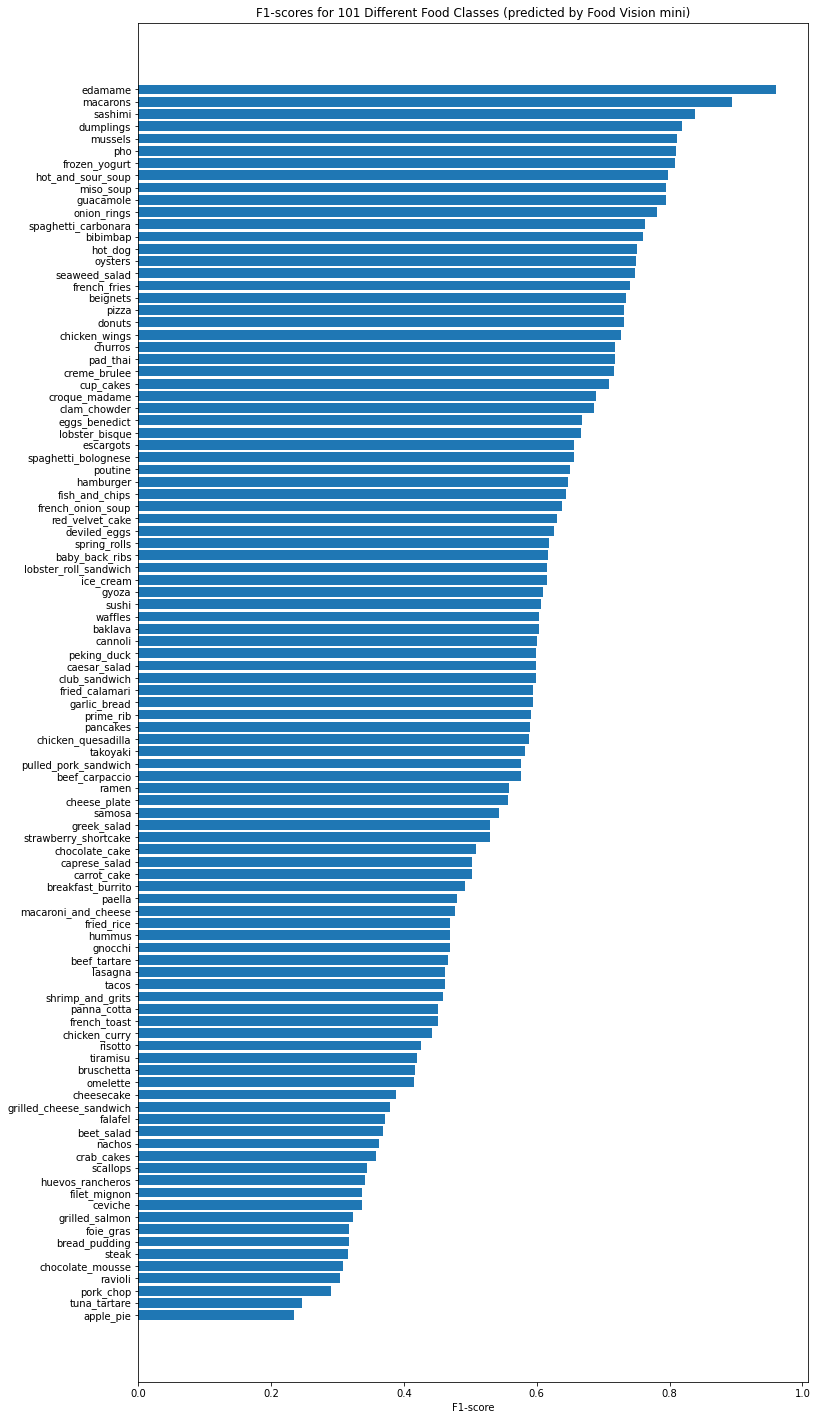

In [94]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

In [ ]:
#